<img src="https://i.imgur.com/oiG2jZl.png">
<center><h1>🧭Indoor Location and Navigation🧭</h1></center>

# 1. Introduction
> 📌 **Goal**: Predicting the indoor position of smartphones 📱 based on a *real-time* sensor 🎯.

> We'll also learn how to use the **GitHub Repository** available through this competition and call the custom functions **without** copy-pasting them into the notebook.

### Libraries📚

In [1]:
# CPU libraries
import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil

mycolors = ["#797D62", "#9B9B7A", "#D9AE94", "#FFCB69", "#D08C60", "#997B66"]

In [2]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, format(value, ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

### W&B Setup
* Create an account on https://wandb.ai (it's free)
* Install `wandb`
* Input your `personal key` of the project ( mine will be secret, as it is confidential :) )

In [3]:
import wandb
os.environ["WANDB_SILENT"] = "true"

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

In [4]:
! wandb login $secret_value_0

In [5]:
# Initialize new project
### project - the name of the overajj project (like the name of the repo in GitHub)
### name/experiment - the name of the run (we'll have multiple runs in 1 project)
run = wandb.init(project="indoor-location-kaggle", name="data-understanding")

> We're all set!

# 2. Data Understanding

* `train` - train path files, organized by *site* and *floor*. Each path file contains the data of a single path on a single floor.
* `test` - test path files, organized by *site* and *floor*. Each path file contains the data of a single path on a single floor, **but without the waypoint (x, y) data**. 
* `metadata` - floor metadata folder, organized by site and floor, which includes the following for each floor:
    * `floor_image.png`
    * `floor_info.json`
    * `geojson_map.json`
    
<img src="https://i.imgur.com/EE98923.png" width=500>

> 📌 **Goal**: The task of this competition is, for a given site-path file, **predict the floor** and **waypoint locations** at the **timestamps** given in the `sample_submission.csv` file.

> ❗ **Note on data quality** ❗: In the training files, you may find occasionally that a line is missing the ending newline character, causing it to run on to the next line. It is up to you how you want to handle this issue. This issue is not found in the test data.

In [6]:
# Get path to all TRAIN & TEST files
train_paths = glob.glob('../input/indoor-location-navigation/train/*/*/*')
test_paths = glob.glob('../input/indoor-location-navigation/test/*')
sites = glob.glob('../input/indoor-location-navigation/metadata/*')

print("No. Files in Train: {:,}".format(len(train_paths)), "\n" +
      "No. Files in Test: {:,}".format(len(test_paths)), "\n" +
      "Total Sites (metadata): {:,}".format(len(sites)))

No. Files in Train: 26,925 
No. Files in Test: 626 
Total Sites (metadata): 204


In [7]:
#  Log to W&B in "data-understanding" experiment
wandb.log({'No. Files in Train': len(train_paths), 
           'No. Files in Test:' : len(test_paths),
           'Total Sites (metadata)' : len(sites)})

## Reading in the data

> ❗ **Note**: The presented data is in `.txt` format and contains A LOT of information. In only 1 `.txt` file (meaning 1 path), there were over 126k lines of information. From 1 file to another, this information varies, so trying to structure it all could be a hassle.

In [8]:
# How 1 path looks
base = '../input/indoor-location-navigation'
path = f'{base}/train/5cd56b5ae2acfd2d33b58549/5F/5d06134c4a19c000086c4324.txt'

with open(path) as p:
    lines = p.readlines()

print("No. Lines in 1 example: {:,}". format(len(lines)), "\n" +
      "Example (5 lines): ", lines[0:5])

No. Lines in 1 example: 126,240 
Example (5 lines):  ['#\tstartTime:1560676618881\n', '#\tSiteID:5cd56b5ae2acfd2d33b58549\tSiteName:百联南方购物中心\tFloorId:5cd56b5be2acfd2d33b5859d\tFloorName:5F\n', '#\tBrand:HUAWEI\tModel:VTR-AL00\tAndroidName:8.0.0\tAPILevel:26\t\n', '#\ttype:1\tname:accelerometer-icm20690\tversion:1\tvendor:invensense\tresolution:0.009576807\tpower:0.23\tmaximumRange:78.4532\n', '#\ttype:4\tname:gyroscope-icm20690\tversion:1\tvendor:invensense\tresolution:1.7453292E-5\tpower:6.1\tmaximumRange:34.906586\n']


# 🔗 2. How to use a GitHub repo on Kaggle?

> 📌 **Goal**: This competition has a [GitHub repo](https://github.com/location-competition/indoor-location-competition-20) available. We can use the `read_data_file` function in the `io_f` file to read in the information ( no additional struggle on our side + no copy-paste and cluttered code :) ).

#### *🙏 🏻Special thanks to [Laura](https://www.kaggle.com/allunia) for teaching me this awesome trick. 🙏🏻*

**Steps**:
* 🦶🏻 - download the repo from [this link](https://github.com/location-competition/indoor-location-competition-20)
* 🦶🏻 - copy the package to the Kaggle environment (`!cp -r path/* ./`)
* 🦶🏻 - import it and use it as you please

In [9]:
!cp -r ../input/indoor-locationnavigation-2021/indoor-location-competition-20-master/indoor-location-competition-20-master/* ./

In [10]:
# Import custom function from the repository
from io_f import read_data_file

# Read in 1 random example
sample_file = read_data_file(path)

# You can access the information for each variable:
print("~~~ Example ~~~")
print("acce: {}".format(sample_file.acce.shape), "\n" +
      "acacce_uncalice: {}".format(sample_file.acce_uncali.shape), "\n" +
      "ahrs: {}".format(sample_file.ahrs.shape), "\n" +
      "gyro: {}".format(sample_file.gyro.shape), "\n" +
      "gyro_uncali: {}".format(sample_file.gyro_uncali.shape), "\n" +
      "ibeacon: {}".format(sample_file.ibeacon.shape), "\n" +
      "magn: {}".format(sample_file.magn.shape), "\n" +
      "magn_uncali: {}".format(sample_file.magn_uncali.shape), "\n" +
      "waypoint: {}".format(sample_file.waypoint.shape), "\n" +
      "wifi: {}".format(sample_file.wifi.shape))

~~~ Example ~~~
acce: (20515, 4) 
acacce_uncalice: (0,) 
ahrs: (20906, 4) 
gyro: (20906, 4) 
gyro_uncali: (20906, 4) 
ibeacon: (392, 3) 
magn: (20906, 4) 
magn_uncali: (20906, 4) 
waypoint: (31, 3) 
wifi: (764, 5)


Now that we know how our data is structured, we can start to explore the floor plans, in other words the paths and different features that could be used to predict the `waypoint`, a particular point in the trace.

Ok, let's take the EDA step by step!

## 🏢 Sites

First, let's look at a random shopping mall and visualize the plan of each floor. For this I've created a custom function, which takes the `site_no` of a site as input, and returns a plt plot of the floor plans in that site.

Below you can see that for this site example there are 8 floors:
* 3 underground: *B1, B2* and *B3*
* 5 above ground: *F1, F2, F3, F4* and *F5*

In [11]:
def show_site_png(site):
    '''This functions outputs the visualization of the .png images available
    in the metadata.
    sites: the code coresponding to 1 site (or building)'''
    
    base = '../input/indoor-location-navigation'
    site_path = f"{base}/metadata/{site}/*/floor_image.png"
    floor_paths = glob.glob(site_path)
    n = len(floor_paths)

    # Create the custom number of rows & columns
    ncols = [ceil(n / 3) if n > 4 else 4][0]
    nrows = [ceil(n / ncols) if n > 4 else 1][0]

    plt.figure(figsize=(16, 10))
    plt.suptitle(f"Site no. '{site}'", fontsize=18)

    # Plot image for each floor
    for k, floor in enumerate(floor_paths):
        plt.subplot(nrows, ncols, k+1)

        image = Image.open(floor)
        image = ImageOps.expand(image, border=15, fill=mycolors[5])

        plt.imshow(image)
        plt.axis("off")
        title = floor.split("/")[5]
        plt.title(title, fontsize=15)
        
        # Log to W&B in "data-understanding" experiment
        wandb.log({"Site Floors Example": plt})

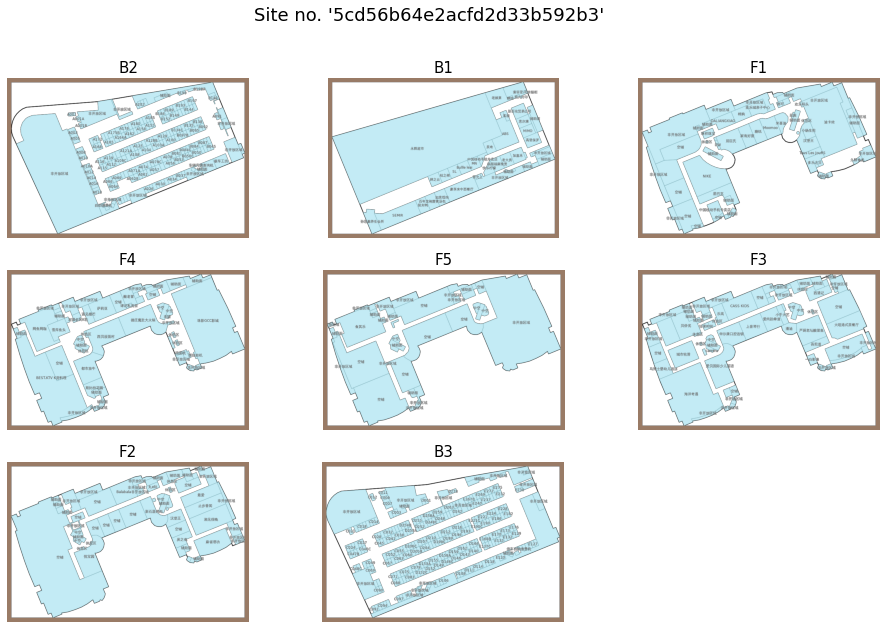

In [12]:
# Let's observe 1 example
# site = '5cd56b64e2acfd2d33b59246'
show_site_png(site='5cd56b64e2acfd2d33b592b3')

## 🛩 How many floors? 

Ok, the site plan looks very interesting, but how many floors do we really have on average for each building?

This information is extremely important, first to observe the *variance* between the sites, and second because the variable `floor` variable is also one of our **target variables**.

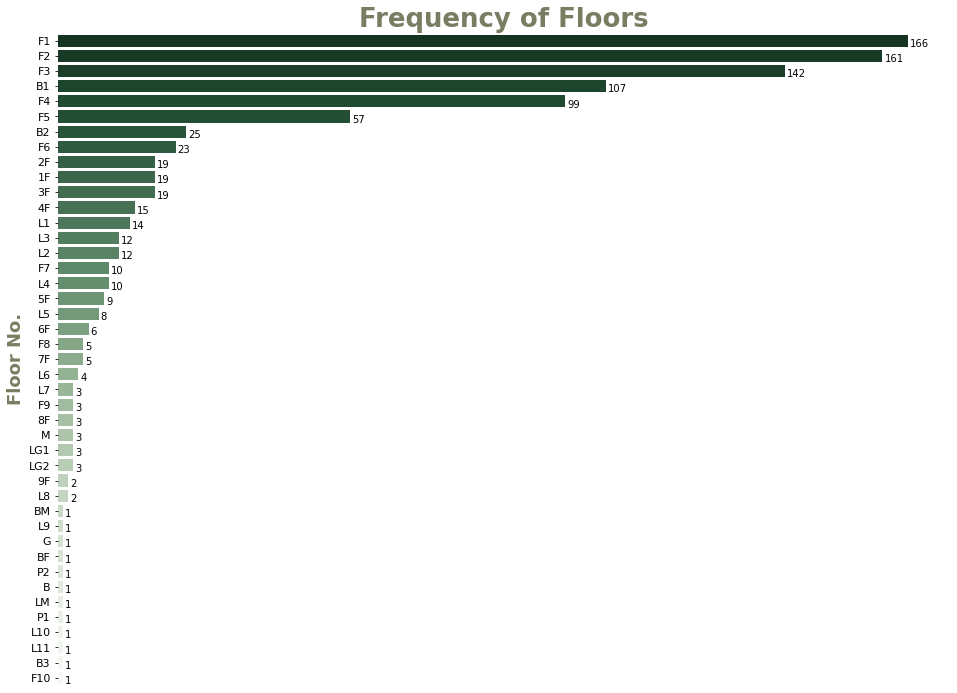

In [13]:
all_floors = glob.glob("../input/indoor-location-navigation/metadata/*/*")
floor_no = []

# Extract only the floor number
for floor in all_floors:
    no = floor.split("/")[5]
    floor_no.append(no)
    
floor_no = pd.DataFrame(floor_no, columns=["No"])
floor_no = floor_no["No"].value_counts().reset_index()
floor_no = floor_no.sort_values("No", ascending=False)

# ~~~~
# PLOT
# ~~~~
plt.figure(figsize=(16, 12))
ax = sns.barplot(data=floor_no, x="No", y="index", palette="Greens_r",
                 saturation=0.4)
show_values_on_bars(ax, h_v="h", space=0.4)
ax.set_title("Frequency of Floors", size = 26, color = mycolors[0], weight='bold')
ax.set_xlabel("")
ax.set_ylabel("Floor No.", size = 18, color = mycolors[0], weight='bold')
plt.xticks([])
plt.yticks(fontsize=11)
sns.despine(left=True, bottom=True);

In [14]:
# Log to W&B in "data-understanding" experiment
### As seaborn direct log is not supported at the moment
### we'll create a custom barplot
data = [[index, no] for (index, no) in zip(floor_no["index"], floor_no["No"])]
table = wandb.Table(data=data, columns=["index", "no"])
wandb.log({"Frequency of Floors" : wandb.plot.bar(table, "index", "no", title="Frequency of Floors")})

> This is how it looks in the W&B dashboard:
<img src="https://i.imgur.com/IpxLc7t.png" width=700>

## Waypoint

The waypoint is our **second and third target** variables. A waypoint is *"a stopping place on a journey"*. Hence, that point would have `x` and `y` coordinates and would belong to a bigger trace.

Let's visualize a random trace in a random building in our data. In the figure below there are:
* A starting point: the smartphone starts at Start Point 0, marked as a big green bullet point.
* A trace: the smartphone moves along the edge of the floor's building, takes a right and the walks straight ahead, sometimes moving back and forth. There are around 30 waypoints along this trace.
* An ending point: the smartphone settles at the End Point, marked with a big red bullet point.

Each point mentioned above is a waypoint and can represent a location on the map that we would need to predict.


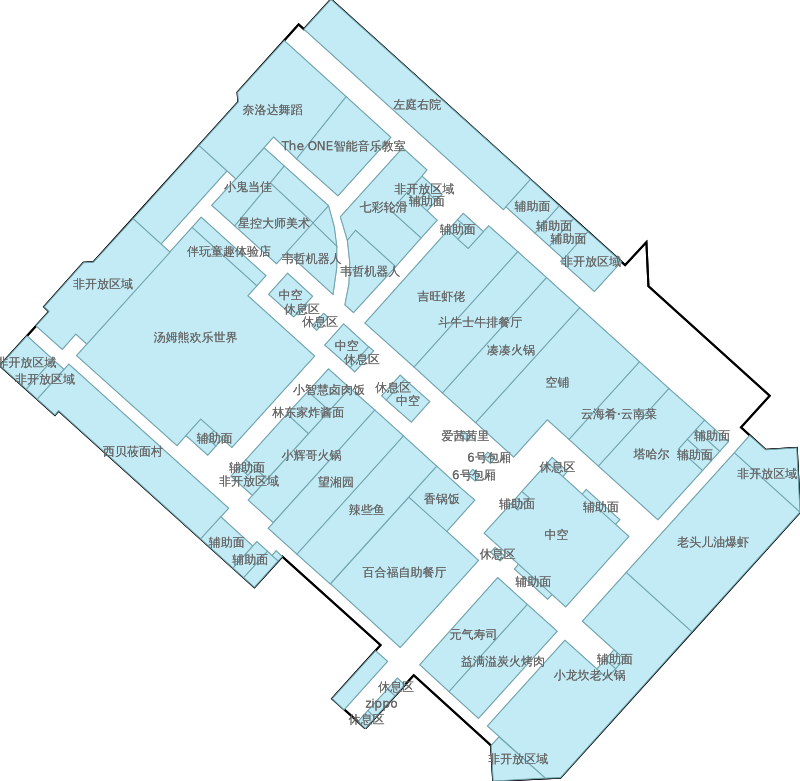

In [15]:
# GitHub functions
from visualize_f import visualize_trajectory, visualize_heatmap

path = f'{base}/train/5cd56b5ae2acfd2d33b58549/5F/5d06134c4a19c000086c4324.txt'

# Read in a sample
example = read_data_file(path)

# ~~~~~~~~~

# Returns timestamp, x, y values
trajectory = example.waypoint
# Removes timestamp (we only need the coordinates)
trajectory = trajectory[:, 1:3]

# Prepare floor_plan coresponding with our example
site = path.split("/")[4]
floorNo = path.split("/")[5]
floor_plan_filename = f'{base}/metadata/{site}/{floorNo}/floor_image.png'

# Prepare width_meter & height_meter
### (taken from the .json file)
json_plan_filename = f'{base}/metadata/{site}/{floorNo}/floor_info.json'
with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)
    
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

# Title
title = "Example of Waypoint"

# ~~~~~~~~~

# Finally, let's plot
visualize_trajectory(trajectory = trajectory,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = title,
                     g_size=755,
                     point_color='#76C1A0',
                     start_color='#007B51',
                     end_color='#9B0000')

## 🧲 Magnetic Strength 

> 📌 **Magnetic Strength**: Any point inside a building is subject to unique magnetic forces. Floors, walls, and objects around the room create a *four-dimensional* map of three-dimensional space and magnetic magnitudes. The magnetic magnitude at any point in space can be measured by reading the x, y, and z magnetic vectors at that point.

Hence, the phone detects *fluctuations* in the magnetic field as the user moves (and as the phone rotates). In the example below, the magnetic field is much more powerful at the beginning of the trajectory, but less strong at the left side of the floor.

#### 📐 mu tesla (1×104 G) - is a derived unit of the magnetic induction 📐


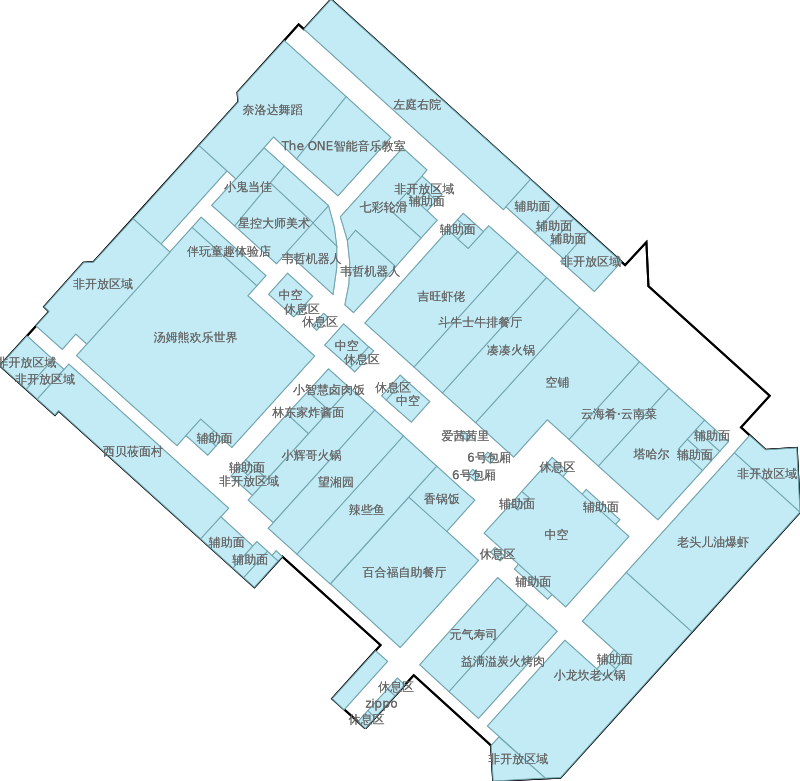

In [16]:
# GitHub functions
from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength

# Extracting the magnetic strength
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position([path])
magnetic_strength = extract_magnetic_strength(mwi_datas)

heat_positions = np.array(list(magnetic_strength.keys()))
heat_values = np.array(list(magnetic_strength.values()))

# Visualize the heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  floor_plan_filename,
                  width_meter, 
                  height_meter, 
                  colorbar_title='mu tesla', 
                  title='Magnetic Strength',
                  g_size=755,
                  colorscale='temps')

## 📶 WiFi 

> 📌 **WiFi Access Points**: The floors of a site can have many WiFi Access Points. Hence, the signals and their strengths will vary widely in different areas.

In the example below you can see that the route is filled with such access points:

This floor has 145 wifi aps (access points).



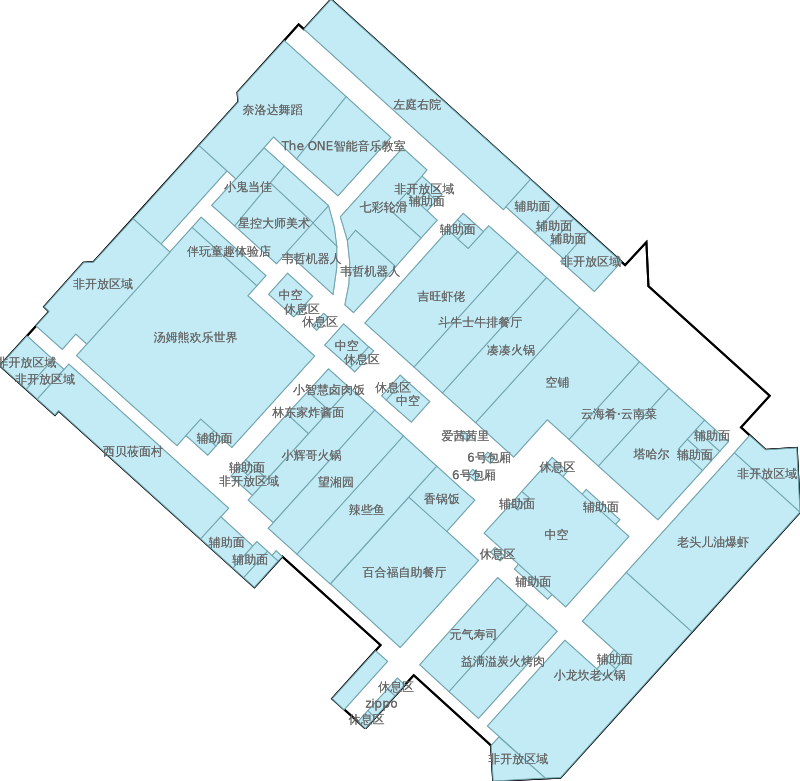

In [17]:
# GitHub Libraries
from main import extract_wifi_rssi, extract_wifi_count

# Get WiFi data
wifi_rssi = extract_wifi_rssi(mwi_datas)
print(f'This floor has {len(wifi_rssi.keys())} wifi aps (access points).')

wifi_counts = extract_wifi_count(mwi_datas)
heat_positions = np.array(list(wifi_counts.keys()))
heat_values = np.array(list(wifi_counts.values()))
# filter out positions that no wifi detected
mask = heat_values != 0
heat_positions = heat_positions[mask]
heat_values = heat_values[mask]

# The heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  floor_plan_filename, 
                  width_meter, 
                  height_meter, 
                  colorbar_title='count', 
                  title=f'WiFi Count',
                  g_size=755,
                  colorscale='temps')

## 🔵🦷 IBeacon (Bluetooth) 

> 📌 **IBeacon**: Beacons work in tandem with mobile apps to trigger particular messages or actions based on rules, such as triggering a push notification when a user is within a certain distance from a beacon.

There are many beacons along the example path, however there is a big portion that has no iBeacons at all (circled in orange), therefore the accuracy in this section for this particular example might be lower.
Note: RSSE is a web feed that can allow a user to keep track of many different websites in a single news aggregator.

#### 📐 dBm (decibel milliwatts) - used as a measure of absolute power; the closer the number is to 0, the better off your signal strength is 📐

This floor has 3 ibeacons.



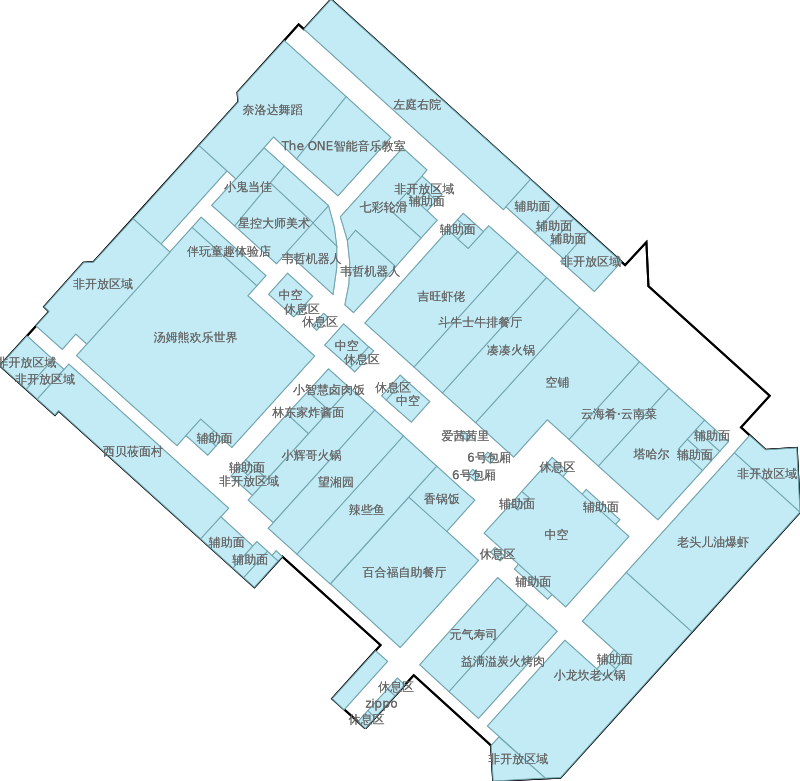

In [18]:
# The GitHub function
from main import extract_ibeacon_rssi

# Getting the iBeacon data
ibeacon_rssi = extract_ibeacon_rssi(mwi_datas)
print(f'This floor has {len(ibeacon_rssi.keys())} ibeacons.')
ibeacon_ummids = list(ibeacon_rssi.keys())
target_ibeacon = ibeacon_ummids[0]
heat_positions = np.array(list(ibeacon_rssi[target_ibeacon].keys()))
heat_values = np.array(list(ibeacon_rssi[target_ibeacon].values()))[:, 0]

# The heatmap
visualize_heatmap(heat_positions, 
                  heat_values, 
                  floor_plan_filename, 
                  width_meter, 
                  height_meter, 
                  colorbar_title='dBm', 
                  title='iBeacon RSSE',
                  g_size=755,
                  colorscale='temps')

In [19]:
# ~ END of EXPERIMENT ~
wandb.finish()
# ~~~~~~~~~~~~~~~~~~~~~

# 3. Understanding the Competition Metric

> 📌 **Note**: Although many notebooks I've seen use the same `comp_metric` function to compute the *Evaluation metric* (as below), it took me a a bit to understand the variable and what they mean. Hence, I've decided to share a bit of information around it for those who skipped a bit too early the informations in the description of the competition (like I did 😅).

`def comp_metric(xhat, yhat, fhat, x, y, f):
    intermediate = np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2)) + 15 * np.abs(fhat-f)
    return intermediate.sum()/xhat.shape[0]`
    
### Explanation

The above formula is simply the Python version of the mathematical function below (provided by the competition):
<img src="https://i.imgur.com/1Z0s7Cc.png" width=500>

In [20]:
from numpy import sqrt, power
from numpy import abs as absolute

In [21]:
def mean_position_error(x_pred, y_pred, f_pred, x_true, y_true, f_true, p=15):
    '''Custom function to evaluate Mean Position Error.
    x: x coordinate of the waypoint position; dtype list()
    y: y coordinate of the waypoint position; dtype list()
    f: exact floor or the building; dtype list()
    p: floor penalty, set to 15 (always)'''
    
    N = len(x_true)
    #1
    formula = sqrt( power(x_pred - x_true, 2) + power(y_pred - y_true, 2) )
    #2
    formula = formula + p * absolute(f_pred - f_true)
    #3
    formula = formula.sum() / N
    
    return formula

### RAPIDS function

In [22]:
from cupy import sqrt as sqrt_g
from cupy import power as power_g
from cupy import abs as abs_g

In [23]:
def mean_position_error_gpu(x_pred, y_pred, f_pred, x_true, y_true, f_true, p=15):
    '''Same, but Faster ;)
    Using RAPIDS here for our XGBoost model later.'''
    
    N = len(x_true)
    formula = sqrt_g( power_g(x_pred - x_true, 2) + power_g(y_pred - y_true, 2) )
    formula = formula + p * abs_g(f_pred - f_true)
    formula = formula.sum() / N
    return formula

# 4. Baseline Model

> 📌 **Note**: Preprocessed data is from [this dataset](https://www.kaggle.com/devinanzelmo/indoor-navigation-and-location-wifi-features) by [Devin Anzelmo](https://www.kaggle.com/devinanzelmo).

In [24]:
def make_submission(predictions, sample_subm, name="base.csv"):
    '''Receives a list of predictions in dataframe format.'''
    final_submission = pd.concat(predictions).reset_index(drop=True)
    final_submission.index = sample_subm.index
    final_submission.to_csv(name)
    print("Submission ready.")

## I. Light GBM

In [25]:
# Import Libraries
import lightgbm as lgb

# ~~~~
# Data
# ~~~~
base_dir = "../input/indoor-navigation-and-location-wifi-features/wifi_features"
train_dir = "/train/*_train.csv"
test_dir = "/test/*_test.csv"


# Paths for train & test files
train_paths = sorted(glob.glob(base_dir + train_dir))
test_paths = sorted(glob.glob(base_dir + test_dir))
sample_subm = pd.read_csv('../input/indoor-location-navigation/sample_submission.csv',
                          index_col=0)

print("Len Train Files: {}".format(len(train_paths)), "\n" +
      "Len Test Files: {}".format(len(test_paths)))

Len Train Files: 24 
Len Test Files: 24


In [26]:
# Initialize new experiment (LGBM)
run = wandb.init(project="indoor-location-kaggle", name="lgbm_train")

wandb.log({'Len Train Files' : len(train_paths),
           'Len Test Files' : len(test_paths)})

> Schema of the "Training loop" (inspired by [Jiwei Liu's work](https://www.kaggle.com/jiweiliu)):
<img src="https://i.imgur.com/UQmdRcz.png" width=750>

#### Code Below

In [27]:
def train_lgbm(train_perc=0.75, version=1, n_estimators=150, num_leaves=127):
    '''
    Training loop
    '''

    f = open(f"lgbm_logs_{version}.txt", "w+")
    lgbm_predictions = []
    
    # Log in W&B
    wandb.log({'n_estimators': n_estimators, 'num_leaves': num_leaves})
    
    k = 1
    for train_path, test_path in zip(train_paths, test_paths):


        # --- Read in data ---
        train_df = pd.read_csv(train_path, index_col=0)
        train_df = train_df.sample(frac=1, random_state=10)

        # Erase last column (which is "site_path_timestamp")
        test_df = pd.read_csv(test_path, index_col=0).iloc[:, :-1]

        # Sample out training and validation data
        ### we need to be careful to choose same information for ALL 3 models
        ### 1 for x, 1 for y and 1 for floor

        train_size = int(len(train_df) * train_perc)


        # --- Data Validation ---
        # Train features + targets
        X_train = train_df.iloc[:train_size, :-4]
        y_train_x = train_df.iloc[:train_size, -4]
        y_train_y = train_df.iloc[:train_size, -3]
        y_train_f = train_df.iloc[:train_size, -2]

        # Valid features + targets
        X_valid = train_df.iloc[train_size:, :-4]
        y_valid_x = train_df.iloc[train_size:, -4]
        y_valid_y = train_df.iloc[train_size:, -3]
        y_valid_f = train_df.iloc[train_size:, -2]


        # --- Model Training ---
        lgbm_x = lgb.LGBMRegressor(n_estimators=n_estimators, num_leaves=num_leaves)
        lgbm_x.fit(X_train, y_train_x)

        lgbm_y = lgb.LGBMRegressor(n_estimators=n_estimators, num_leaves=num_leaves)
        lgbm_y.fit(X_train, y_train_y)

        lgbm_f = lgb.LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves)
        lgbm_f.fit(X_train, y_train_f)


        # --- Model Validation Predictions ---
        preds_x = lgbm_x.predict(X_valid)
        preds_y = lgbm_y.predict(X_valid)
        preds_f = lgbm_f.predict(X_valid).astype(int)
        
        mpe = mean_position_error(preds_x, preds_y, preds_f,
                                  y_valid_x, y_valid_y, y_valid_f)
        print("{} | MPE: {}".format(k, mpe))
        # Save logs
        with open(f"lgbm_logs_{version}.txt", 'a+') as f:
            print("{} | MPE: {}".format(k, mpe), file=f)
        
        # Log MPE of this experiment
        wandb.log({'MPE' : mpe, 'step' : k})
        
        k+=1


        # --- Model Test Predictions ---
        test_preds_x = lgbm_x.predict(test_df)
        test_preds_y = lgbm_y.predict(test_df)
        test_preds_f = lgbm_f.predict(test_df).astype(int)

        all_test_preds = pd.DataFrame({'floor' : test_preds_f,
                                       'x' : test_preds_x, 
                                       'y' : test_preds_y})
        lgbm_predictions.append(all_test_preds)
    
    
    return lgbm_predictions

### Training

In [28]:
# Uncomment line below to train your own model
# lgbm_predictions = train_lgbm(train_perc = 0.75, version=1)

# # Logs from my training:
print(open('../input/indoor-locationnavigation-2021/lgbm_logs_1.txt', "r").read())

1 | MPE: 4.623747326090272
2 | MPE: 5.0080171611895
3 | MPE: 4.930738883281883
4 | MPE: 3.0397583703110413
5 | MPE: 18.07317586210189
6 | MPE: 2.979526658237401
7 | MPE: 4.2606883662553985
8 | MPE: 3.943854519533772
9 | MPE: 4.7637034333616
10 | MPE: 7.286866237889805
11 | MPE: 3.60652932480103
12 | MPE: 3.739371993966272
13 | MPE: 8.669980019131534
14 | MPE: 4.63109306665204
15 | MPE: 2.3770735119279283
16 | MPE: 3.560376380902074
17 | MPE: 3.876162399722622
18 | MPE: 3.5846589363866106
19 | MPE: 5.073309589578127
20 | MPE: 5.564631679860874
21 | MPE: 7.053907437948128
22 | MPE: 4.034205784770025
23 | MPE: 5.558653278200884
24 | MPE: 8.027944936609352



> ❗**Attention**: *5th* dataframe had a BIG error (jumped from ~4 on average to 18). This case HAS to be taken into consideration, as the models seems to be underfitting. The *10th, 13th, 21st* have big MPE as well.

### Submission LGBM

In [29]:
# Uncomment line below to make your own submission
# make_submission(lgbm_predictions, sample_subm, name="lgbm_base.csv")

# My submission:
lgbm_predictions = pd.read_csv("../input/indoor-locationnavigation-2021/lgbm_base.csv")
lgbm_predictions.to_csv("lgbm_base.csv", index=False)

In [30]:
# ~ END of EXPERIMENT ~
wandb.finish()
# ~~~~~~~~~~~~~~~~~~~~~

## II. XGBoost - Faster with RAPIDS

> 📌 **Note**: I will use a combination of **RAPIDS** libraries on GPU and XGBoost as one of my base models. More information on this open source suite of libraries [here](https://rapids.ai/).

In [31]:
# Libraries
import cudf
import cupy
import cuml
import xgboost

# Adjust floor function
### As the Multiclass XGBoost takes only labels between [0, n)
### But we have negative floor values
def adjust_floor(df, col_name):
    '''Adjusts the floor to be >= 0.
    Also returns the number fo classes (also used to complete classification).'''
    num_classes = df[col_name].nunique()
    smallest = df[col_name].unique().min()
    df[col_name] = df[col_name] - smallest
    
    return df[col_name], num_classes, smallest

In [32]:
# Initialize new experiment (XGB)
run = wandb.init(project="indoor-location-kaggle", name="xgb_train")

wandb.log({'Len Train Files' : len(train_paths),
           'Len Test Files' : len(test_paths)})

In [33]:
def train_xgb(train_perc=0.75, version=1):
    '''
    Training loop
    '''

    f = open(f"xgb_logs_{version}.txt", "w+")
    xgb_predictions = []
    
    
    k = 1
    for train_path, test_path in zip(train_paths, test_paths):


        # --- Read in data ---
        train_df = cudf.read_csv(train_path, index_col=0)
        train_df = train_df.sample(frac=1, random_state=10)
        train_df["f"], num_classes, smallest = adjust_floor(train_df, 'f')

        # Erase last column (which is "site_path_timestamp")
        test_df = cudf.read_csv(test_path, index_col=0).iloc[:, :-1]

        # Sample out training and validation data
        ### we need to be careful to choose same information for ALL 3 models
        ### 1 for x, 1 for y and 1 for floor

        train_size = int(len(train_df) * train_perc)


        # --- Data Validation ---
        # Train features + targets
        X_train = train_df.iloc[:train_size, :-4]
        y_train_x = train_df.iloc[:train_size, -4]
        y_train_y = train_df.iloc[:train_size, -3]
        y_train_f = train_df.iloc[:train_size, -2]

        # Valid features + targets
        X_valid = train_df.iloc[train_size:, :-4]
        y_valid_x = cupy.asanyarray(train_df.iloc[train_size:, -4])
        y_valid_y = cupy.asanyarray(train_df.iloc[train_size:, -3])
        y_valid_f = cupy.asanyarray(train_df.iloc[train_size:, -2])
        
        
        # --- Parameters ---
        regr_params = {'max_depth' : 4, 'max_leaves' : 2**4, 
                       'tree_method' : 'gpu_hist', 'objective' : 'reg:squarederror',
                       'grow_policy' : 'lossguide', 'colsample_bynode': 0.8}
        classif_params = {'max_depth' : 4, 'max_leaves' : 2**4,
                          'tree_method' : 'gpu_hist', 'objective' : 'multi:softmax',
                          'num_class' : num_classes, 'grow_policy' : 'lossguide',
                          'colsample_bynode': 0.8, 'verbosity' : 0}
        
        # Log once to W&B
        if k == 1:
            wandb.log(regr_params)
            wandb.log(classif_params)


        # --- Model Training ---
        trainMatrix_x = xgboost.DMatrix(data=X_train, label=y_train_x)
        xgboost_x = xgboost.train(params=regr_params, dtrain=trainMatrix_x)

        trainMatrix_y = xgboost.DMatrix(data=X_train, label=y_train_y)
        xgboost_y = xgboost.train(params=regr_params, dtrain=trainMatrix_y)

        trainMatrix_f = xgboost.DMatrix(data=X_train, label=y_train_f)
        xgboost_f = xgboost.train(params=classif_params, dtrain=trainMatrix_f)


        # --- Model Validation Predictions ---
        preds_x = cupy.asanyarray(xgboost_x.predict(xgboost.DMatrix(X_valid)))
        preds_y = cupy.asanyarray(xgboost_y.predict(xgboost.DMatrix(X_valid)))
        preds_f = cupy.asanyarray(xgboost_f.predict(xgboost.DMatrix(X_valid)).astype(int))

        mpe = mean_position_error_gpu(preds_x, preds_y, preds_f,
                                      y_valid_x, y_valid_y, y_valid_f)
        print("{} | MPE: {}".format(k, mpe))
        # Save logs
        with open(f"xgb_logs_{version}.txt", 'a+') as f:
            print("{} | MPE: {}".format(k, mpe), file=f)
        
        # Log MPE of this experiment
        wandb.log({'MPE' : mpe, 'step' : k})
        
        k+=1


        # --- Model Test Predictions ---
        test_preds_x = xgboost_x.predict(xgboost.DMatrix(test_df))
        test_preds_y = xgboost_y.predict(xgboost.DMatrix(test_df))
        test_preds_f = xgboost_f.predict(xgboost.DMatrix(test_df)).astype(int) + smallest

        all_test_preds = pd.DataFrame({'floor' : test_preds_f,
                                       'x' : test_preds_x, 
                                       'y' : test_preds_y})
        xgb_predictions.append(all_test_preds)
    
    
    return xgb_predictions

### Training

In [34]:
# Uncomment line below to train your own model
# xgb_predictions = train_xgb(train_perc=0.75, version=1)

# Logs from my training:
print(open('../input/indoor-locationnavigation-2021/xgb_logs_1.txt', "r").read())

1 | MPE: 31.722596381431448
2 | MPE: 89.99277702764978
3 | MPE: 23.580584812011587
4 | MPE: 29.323373083856993
5 | MPE: 105.9649880561691
6 | MPE: 6.596278791214304
7 | MPE: 52.99351511314656
8 | MPE: 38.63247417985888
9 | MPE: 19.479155623445667
10 | MPE: 72.45020349701674
11 | MPE: 17.980370840449986
12 | MPE: 40.07532460159101
13 | MPE: 54.76046792632095
14 | MPE: 37.50876442379283
15 | MPE: 14.521354097009107
16 | MPE: 20.122748149358383
17 | MPE: 37.70662498713891
18 | MPE: 11.094332836133685
19 | MPE: 57.78072707405507
20 | MPE: 16.989560468686516
21 | MPE: 23.723839622749146
22 | MPE: 40.45180690812908
23 | MPE: 47.75562565355733
24 | MPE: 64.96428083986659



### Submission

In [35]:
# Uncomment line below to make your own submission
# make_submission(xgb_predictions, sample_subm, name="xgb_base.csv")

# My submission:
xgb_predictions = pd.read_csv("../input/indoor-locationnavigation-2021/xgb_base.csv")
xgb_predictions.to_csv("xgb_base.csv", index=False)

In [36]:
# ~ END of EXPERIMENT ~
wandb.finish()
# ~~~~~~~~~~~~~~~~~~~~~

# 5. Save W&B Submissions and Logs

> We can save the predictions and logs to W&B.

In [37]:
# Submissions
### we can save the predictions in W&B
run = wandb.init(project='indoor-location-kaggle', name='submissions')
artifact = wandb.Artifact(name='submissions', 
                          type='dataset')

artifact.add_file("../input/indoor-locationnavigation-2021/lgbm_base.csv")
artifact.add_file("../input/indoor-locationnavigation-2021/xgb_base.csv")

wandb.log_artifact(artifact)
wandb.finish()

In [38]:
# Logs
### we can save the predictions in W&B
run = wandb.init(project='indoor-location-kaggle', name='training_logs')
artifact = wandb.Artifact(name='training_logs', 
                          type='dataset')

artifact.add_file("../input/indoor-locationnavigation-2021/lgbm_logs_1.txt")
artifact.add_file("../input/indoor-locationnavigation-2021/xgb_logs_1.txt")

wandb.log_artifact(artifact)
wandb.finish()

> The Artifact section of the project:
<img src="https://i.imgur.com/KqzJuFL.png">

# 🥙 Blending Stirring Cooking 

> First let's compare the 2 model's predictions. (needs more work)

In [39]:
# # Read in data
# lgb_preds = pd.read_csv("../input/indoor-locationnavigation-2021/lgbm_base.csv")
# xgb_preds = pd.read_csv("../input/indoor-locationnavigation-2021/xgb_base.csv")

# sample_submission = pd.read_csv("../input/indoor-location-navigation/sample_submission.csv")

# # Sample Submission
# sample_submission["x"] = lgb_preds["x"] * 0.9 + xgb_preds["x"] * 0.1
# sample_submission["y"] = lgb_preds["y"] * 0.9 + xgb_preds["y"] * 0.1

# sample_submission.to_csv("blend1.csv", index=False)

<img src="https://i.imgur.com/cUQXtS7.png">

# ⌨️🎨 Specs on how I prepped & trained 
### (on my local machine)
* Z8 G4 Workstation 🖥
* 2 CPUs & 96GB Memory 💾
* NVIDIA Quadro RTX 8000 🎮
* RAPIDS version 0.17 🏃🏾‍♀️